In [1]:
from djccx.frd.readfrd import readfrd
import os,glob

In [2]:
from matplotlib import pyplot as plt

In [3]:
frds_files = glob.glob("*/*/*.frd")

In [4]:

def localread(x):

    try:
        return readfrd(x)
    except:
        return 0
ifrds = [ localread(ifr) for ifr in frds_files ]

In [5]:
import numpy as np

F3 13892.902353231082
F3 3536.573004004682
F3 1266.2221157852978
F3 2381.136799954356
F3 1838.1055199807774
F3 2340.186797519485


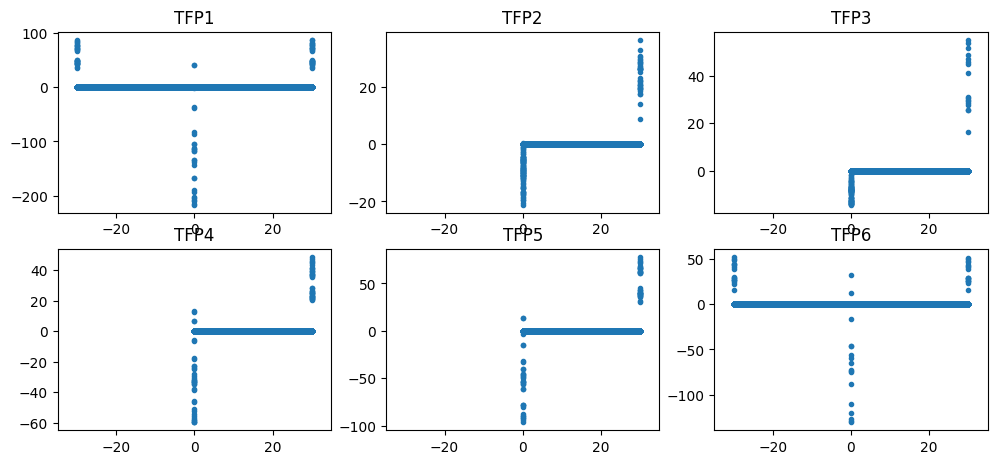

In [6]:
fig = plt.figure(figsize=(12,8))
F3_span = []
factor = [ 4,4,2,2,1,2]
tt = []
for j,ifr in enumerate(ifrds):
    plt.subplot(3,3,j+1)
    data = ifr["data"]
    plt.plot(data["x"], data["F3"],".")
    plt.xlim(-35,35)
    plt.title("TFP" + str(j+1))

    # select x>-10 and x<10
    F3 = data["F3"][data["x"]>-10]
    F3 = F3[data["x"]<10]
    F3 = - np.sum(F3)*factor[j]
    print("F3",F3)
    F3_span.append(F3)

    ti = np.max(data["z"]) - np.min(data["z"])
    tt.append(ti)

In [7]:
F3_span = np.array(F3_span)
tt = np.array(tt)

In [8]:
P = F3_span
B = 25
L = 60
U = 5
Eflex = (P*L**3)/(4*U*B*tt**3) * 1e-3

In [9]:
import pandas as pd

In [10]:
df_pred_file = "../../01_metodo/02_flexion/04_optim_stress/df_pred.csv"
# df_pred_file = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\02_flexion\04_optim_stress\df_pred.csv"
df_pred = pd.read_csv(df_pred_file)

In [11]:
Eb_pred = df_pred["Eb [GPa]"]

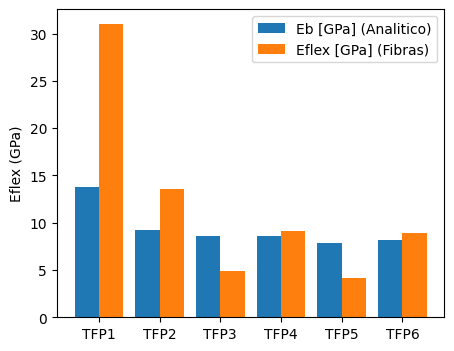

In [12]:
# bar plot 
# TFP1, TFP2, TFP3, TFP4, TFP5, TFP6
fig = plt.figure(figsize=(5,4))
xp = np.arange(len(Eb_pred))
plt.bar(xp, Eb_pred, width=0.4, label="Eb [GPa] (Analitico)")
plt.bar(xp+0.4, Eflex, width=0.4, label="Eflex [GPa] (Fibras)")
plt.ylabel("Eflex (GPa)")
plt.xticks(xp+0.2, ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"])
plt.legend()

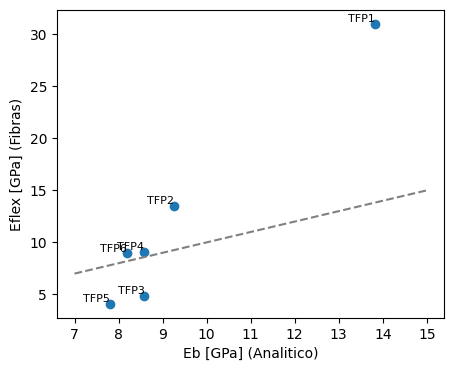

In [13]:
#plot vs 
plt.figure(figsize=(5,4))
plt.plot(Eb_pred, Eflex, "o")
plt.xlabel("Eb [GPa] (Analitico)")
plt.ylabel("Eflex [GPa] (Fibras)")
#1:1 line
x = np.linspace(7, 15, 100)
plt.plot(x, x, "--", color="gray")

# text 
for i, txt in enumerate(["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]):
    plt.annotate(txt, (Eb_pred[i], Eflex[i]), fontsize=8, ha='right', va='bottom')

In [14]:
P1_json_files = glob.glob("*/*.json")

In [15]:
from loadsavejson.loadjson import loadjson

In [16]:
P1_json_files

['TPF5/P1.json',
 'TPF1/P1.json',
 'TPF2/P1.json',
 'TPF4/P1.json',
 'TPF6/P1.json',
 'TPF3/P1.json']

In [17]:
P1_json = [ loadjson(x) for x in P1_json_files ]

In [18]:
Sfibre = 1243.05186
# Sfibre = 300

Smatrix = 620.94557
# Smatrix = 200

P1_max = [ x["P1_max"] for x in P1_json ]
P1_max = np.array(P1_max)

P1_resina = [ x["P1_max_resina"] for x in P1_json ]
sigma_exp = (3/2)*F3_span*L/(B*tt**2)

In [19]:
K_fibra = P1_max/sigma_exp
K_resina = P1_resina/sigma_exp

S_TPFi = [ np.min([Sfibre/K_fibra[i], Smatrix/K_resina[i]]) 
          for i in range(len(K_fibra)) ]
S_TPFi = np.array(S_TPFi)

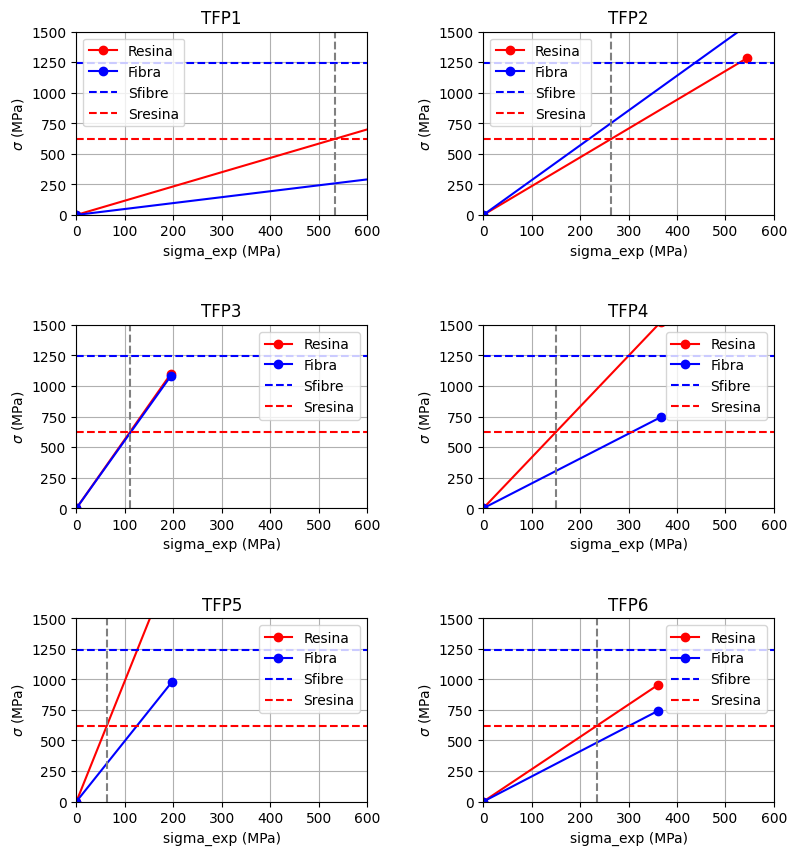

In [20]:
fig = plt.figure(figsize=(9,10))
#padding between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(6):

    plt.subplot(3,2,i+1)
    plt.plot([0,sigma_exp[i]], [0,P1_resina[i]], "o-", label="Resina",color="r")
    plt.plot([0,sigma_exp[i]], [0,P1_max[i]], "o-", label="Fibra",color="b")
    # horizontal line
    plt.axhline(y=Sfibre, linestyle='--', label="Sfibre",color="b")
    plt.axhline(y=Smatrix, linestyle='--', label="Sresina",color="r")

    # vertical line
    plt.axvline(x=S_TPFi[i], linestyle='--', color="gray")
    plt.ylabel(r"$\sigma$ (MPa)")
    plt.xlabel("sigma_exp (MPa)")
    plt.grid()
    plt.title("TFP" + str(i+1))
    plt.ylim(0, 1500)
    plt.xlim(0, 600)
    plt.legend()

In [21]:
from validation.FullExperimental import FullExperimental
df = FullExperimental()
Sb_expiremental = df["Sb [MPa]"]["mean"].values
Sb_expiremental

array([134.99666667, 117.43      , 128.05333333, 141.70333333,
       107.43333333, 114.30666667])

In [22]:
def PredFEM(Sfibre,Smatrix):
    K_fibra = P1_max/sigma_exp
    K_resina = P1_resina/sigma_exp

    S_TPFi = [ np.min([Sfibre/K_fibra[i], Smatrix/K_resina[i]]) 
            for i in range(len(K_fibra)) ]
    S_TPFi = np.array(S_TPFi)

    return S_TPFi


In [23]:
S_TPFi = PredFEM(Sfibre, Smatrix)
S_TPFi

array([532.90581286, 263.63944129, 110.08540523, 149.29856035,
        62.86955339, 234.60617836])

In [24]:
#find P1_max_opt, P1_resina_opt
def find_optimal_P1(Sfibre, Smatrix):
    S_TPFi = PredFEM(Sfibre, Smatrix)

    dx = (Smatrix-Sfibre )
    return np.abs((S_TPFi - Sb_expiremental)**2).sum() + 10*np.max([0,dx])

from scipy.optimize import minimize

x0 = np.array([0,1])
res = minimize(lambda x: find_optimal_P1(x[0], x[1]),
                    x0,
                    method='Nelder-Mead',
                    options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 27112.797553
         Iterations: 165
         Function evaluations: 358


In [25]:
P1_fibra_opt = res.x[0]
P1_resina_opt = res.x[1]
print("P1_fibra_opt",P1_fibra_opt)
print("P1_resina_opt",P1_resina_opt)

P1_fibra_opt 322.30734196418706
P1_resina_opt 238.60416763724277


In [26]:
S_TPFi_opt = PredFEM(P1_fibra_opt, P1_resina_opt)


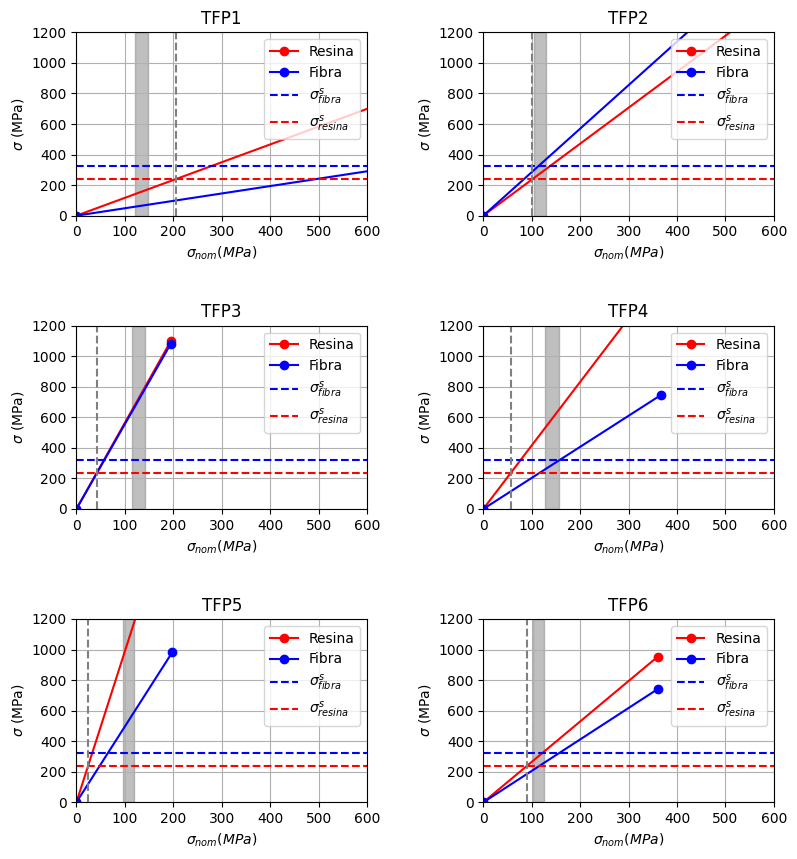

In [27]:
fig = plt.figure(figsize=(9,10))
#padding between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(6):

    plt.subplot(3,2,i+1)
    plt.plot([0,sigma_exp[i]], [0,P1_resina[i]], "o-", label="Resina",color="r")
    plt.plot([0,sigma_exp[i]], [0,P1_max[i]], "o-", label="Fibra",color="b")
    # horizontal line
    plt.axhline(y=P1_fibra_opt, linestyle='--', label="$\sigma_{fibra}^s$",
                color="b")
    plt.axhline(y=P1_resina_opt, linestyle='--', label="$\sigma_{resina}^s$",
                color="r")

    # experimental vertical line
    # 10% rectangle vertical line
    plt.fill_betweenx([0, 1200], 
                      Sb_expiremental[i]-Sb_expiremental[i]*0.1, 
                      Sb_expiremental[i]+Sb_expiremental[i]*0.1, 
                      color="gray", alpha=0.5)
    
    # vertical line
    plt.axvline(x=S_TPFi_opt[i], linestyle='--', color="gray")
    plt.ylabel(r"$\sigma$ (MPa)")
    plt.xlabel(r"$\sigma_{nom} (MPa)$")
    plt.grid()
    plt.title("TFP" + str(i+1))
    plt.ylim(0, 1200)
    plt.xlim(0, 600)
    plt.legend()

In [28]:
df_pred_an_file = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\02_flexion\04_optim_stress\df_pred.csv"
df_pred_an_file = "../../01_metodo/02_flexion/04_optim_stress/df_pred.csv"
df_pred_an = pd.read_csv(df_pred_an_file)

In [29]:
Sb = df_pred_an["Sb [MPa]"]


([<matplotlib.axis.XTick at 0x7f90c843b0d0>,
 [Text(0.2, 0, 'TFP1'),
  Text(1.2, 0, 'TFP2'),
  Text(2.2, 0, 'TFP3'),
  Text(3.2, 0, 'TFP4'),
  Text(4.2, 0, 'TFP5'),
  Text(5.2, 0, 'TFP6')])

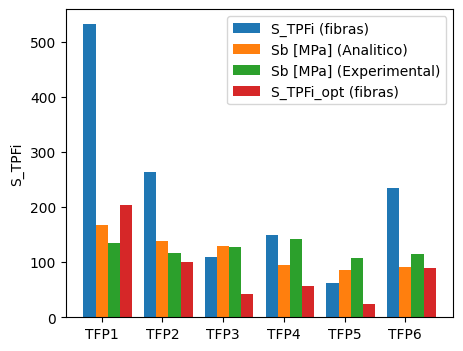

In [30]:
#bar plot 
lables = ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]

fig = plt.figure(figsize=(5,4))
xp = np.arange(len(S_TPFi))
plt.bar(xp, S_TPFi, width=0.2, label="S_TPFi (fibras)")
plt.bar(xp+0.2, Sb, width=0.2, label="Sb [MPa] (Analitico)")
plt.bar(xp+0.4, Sb_expiremental, width=0.2, label="Sb [MPa] (Experimental)")
plt.bar(xp+0.6, S_TPFi_opt, width=0.2, label="S_TPFi_opt (fibras)")
plt.ylabel("S_TPFi")
plt.legend()
# TFP1, TFP2, TFP3, TFP4, TFP5, TFP6
plt.xticks(xp+0.2, ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"])

(0.0, 580.0)

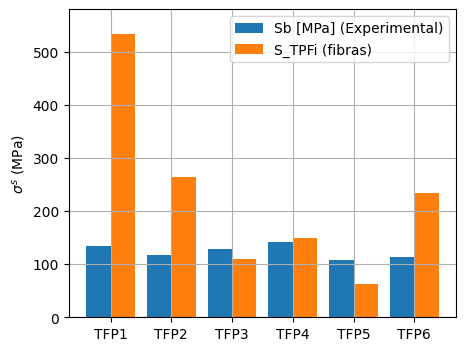

In [31]:
#bar plot 
lables = ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]

fig = plt.figure(figsize=(5,4))
xp = np.arange(len(S_TPFi))
plt.bar(xp-0.2, Sb_expiremental, width=0.4, label="Sb [MPa] (Experimental)")
plt.bar(xp+0.2, S_TPFi, width=0.4, label="S_TPFi (fibras)")
plt.ylabel(r"$\sigma^s$ (MPa)")
plt.legend()
# TFP1, TFP2, TFP3, TFP4, TFP5, TFP6
plt.xticks(xp, ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"])
plt.grid()
#
plt.ylim(0,580)
# MPa 


(0.0, 180.0)

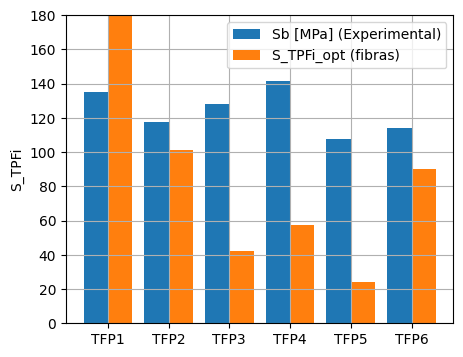

In [32]:
#bar plot 
lables = ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]

fig = plt.figure(figsize=(5,4))
xp = np.arange(len(S_TPFi))
plt.bar(xp-0.2, Sb_expiremental, width=0.4, label="Sb [MPa] (Experimental)")
plt.bar(xp+0.2, S_TPFi_opt, width=0.4, label="S_TPFi_opt (fibras)")
plt.ylabel("S_TPFi")
plt.legend()
# TFP1, TFP2, TFP3, TFP4, TFP5, TFP6
plt.xticks(xp, ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"])
plt.grid()
#
plt.ylim(0,180)

(0.0, 30.0)

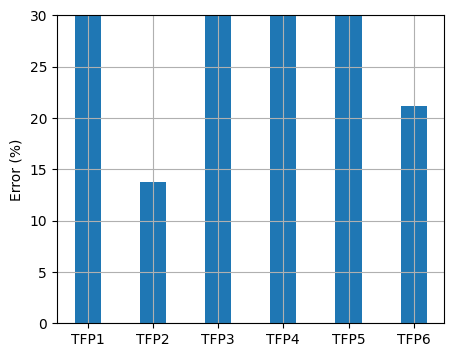

In [33]:
# error 
error = np.abs(S_TPFi_opt - Sb_expiremental)/Sb_expiremental*100
fig = plt.figure(figsize=(5,4))
plt.bar(xp, error, width=0.4, label="Error (%)");
plt.ylabel("Error (%)")
plt.xticks(xp, ["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]);
error_mean = np.mean(error)
error_std = np.std(error)
plt.axhline(y=error_mean, linestyle='--', color="gray")
plt.grid()
plt.ylim(0, 30)

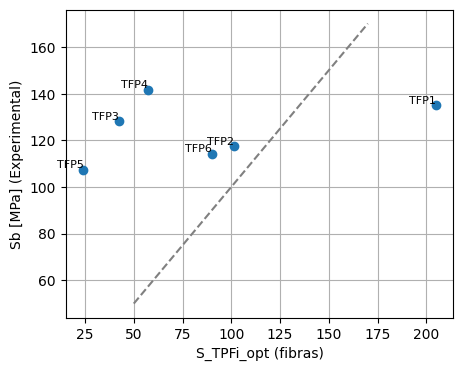

In [34]:
# fibras 
# 1 vs 1 
fig = plt.figure(figsize=(5,4))
# STPFi vs Sb_exp
plt.plot(S_TPFi_opt, Sb_expiremental, "o")
# 1:1 line
x = np.linspace(50,170, 100)
plt.plot(x, x, "--", color="gray")
plt.xlabel("S_TPFi_opt (fibras)")
plt.ylabel("Sb [MPa] (Experimental)")
plt.grid()
# text
for i, txt in enumerate(["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]):
    plt.annotate(txt, (S_TPFi_opt[i], Sb_expiremental[i]), 
                 fontsize=8, ha='right', va='bottom')

In [35]:
F3_span

array([13892.90235323,  3536.573004  ,  1266.22211579,  2381.13679995,
        1838.10551998,  2340.18679752])

In [36]:
os.getcwd()

'/home/djoroya/projects/CITISENS/CITISENS_Composite/scripts_finals/02_metodo/02_flexion'

In [37]:
Force_multilayer_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_Modelo_MultiCapa\T02_NumericalModelNOPBC\output_force.csv"
Force_multilayer_path = "../../../scripts/T02_Modelo_MultiCapa/T02_NumericalModelNOPBC/output_force.csv"
Force_multilayer = pd.read_csv(Force_multilayer_path)
Force_multilayer = Force_multilayer["Force"].values

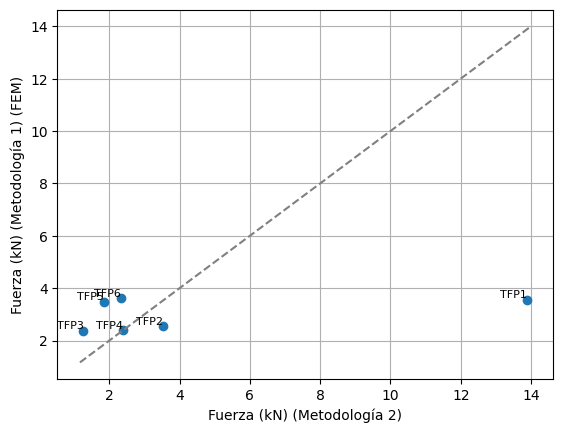

In [38]:
plt.plot(1e-3*F3_span,
         1e-3*Force_multilayer, "o")
# 1vs 1 line
eps = 101e-3
x = np.linspace(min(1e-3*F3_span)-eps, 
                max(1e-3*F3_span)+eps, 100)
plt.plot(x, x, "--", color="gray")
# text TFP1, TFP2, TFP3, TFP4, TFP5, TFP6
for i, txt in enumerate(["TFP1", "TFP2", "TFP3", "TFP4", "TFP5", "TFP6"]):
    plt.annotate(txt, (1e-3*F3_span[i], 
                       1e-3*Force_multilayer[i]), fontsize=8, ha='right', va='bottom')

# force 
plt.xlabel("Fuerza (kN) (Metodología 2)")
plt.ylabel("Fuerza (kN) (Metodología 1) (FEM)")
plt.grid()

In [39]:
summaries_multicapa_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_Modelo_MultiCapa\T02_NumericalModelNOPBC\summaries.json"
summaries_multicapa_path = "../../../scripts/T02_Modelo_MultiCapa/T02_NumericalModelNOPBC/summaries.json"
from loadsavejson.loadjson import loadjson

summaries_multicapa = loadjson(summaries_multicapa_path)
summaries_multicapa = summaries_multicapa["summaries"]

In [40]:
summaries_multicapa[0]

{'layers': ['Y', 'Y', 'nucleo', 'Y', 'Y'],
 'P1': [[0.0, 413.2557686907389, 826.511819911243],
  [0.0, 270.22531936034557, 540.450451351391],
  [0.0, 4.868031741125714, 9.736062196946502],
  [0.0, 56.637201305262465, 113.27447240935112],
  [0.0, -12.843371817091452, -25.68698981172429]],
 'F3': [-0.0, 1775.63158, 3551.2637799999998],
 'sigma_exp': [-0.0, 273.5533698089779, 547.1068351350052]}

In [41]:
layers = summaries_multicapa[0]["layers"]

In [42]:
st_df_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\02_flexion\04_optim_stress\Sl.csv"
st_df_path = "../../../scripts_finals/01_metodo/02_flexion/04_optim_stress/Sl.csv"
df_st = pd.read_csv(st_df_path)
df_st

,Unnamed: 0,0
0,S_fibra,651.843390
1,S_matrix,620.945570
2,S_X,473.050229
3,S_SX,195.889233
4,S_Y,266.080492
5,S_SY,93.029122


In [43]:
St_layers = {
    "X"   : df_st.T[2].values[1],
    "SX"  : df_st.T[3].values[1],
    "Y"   : df_st.T[4].values[1],
    "SY"  : df_st.T[5].values[1],
    "nucleo" : 0.0,
}

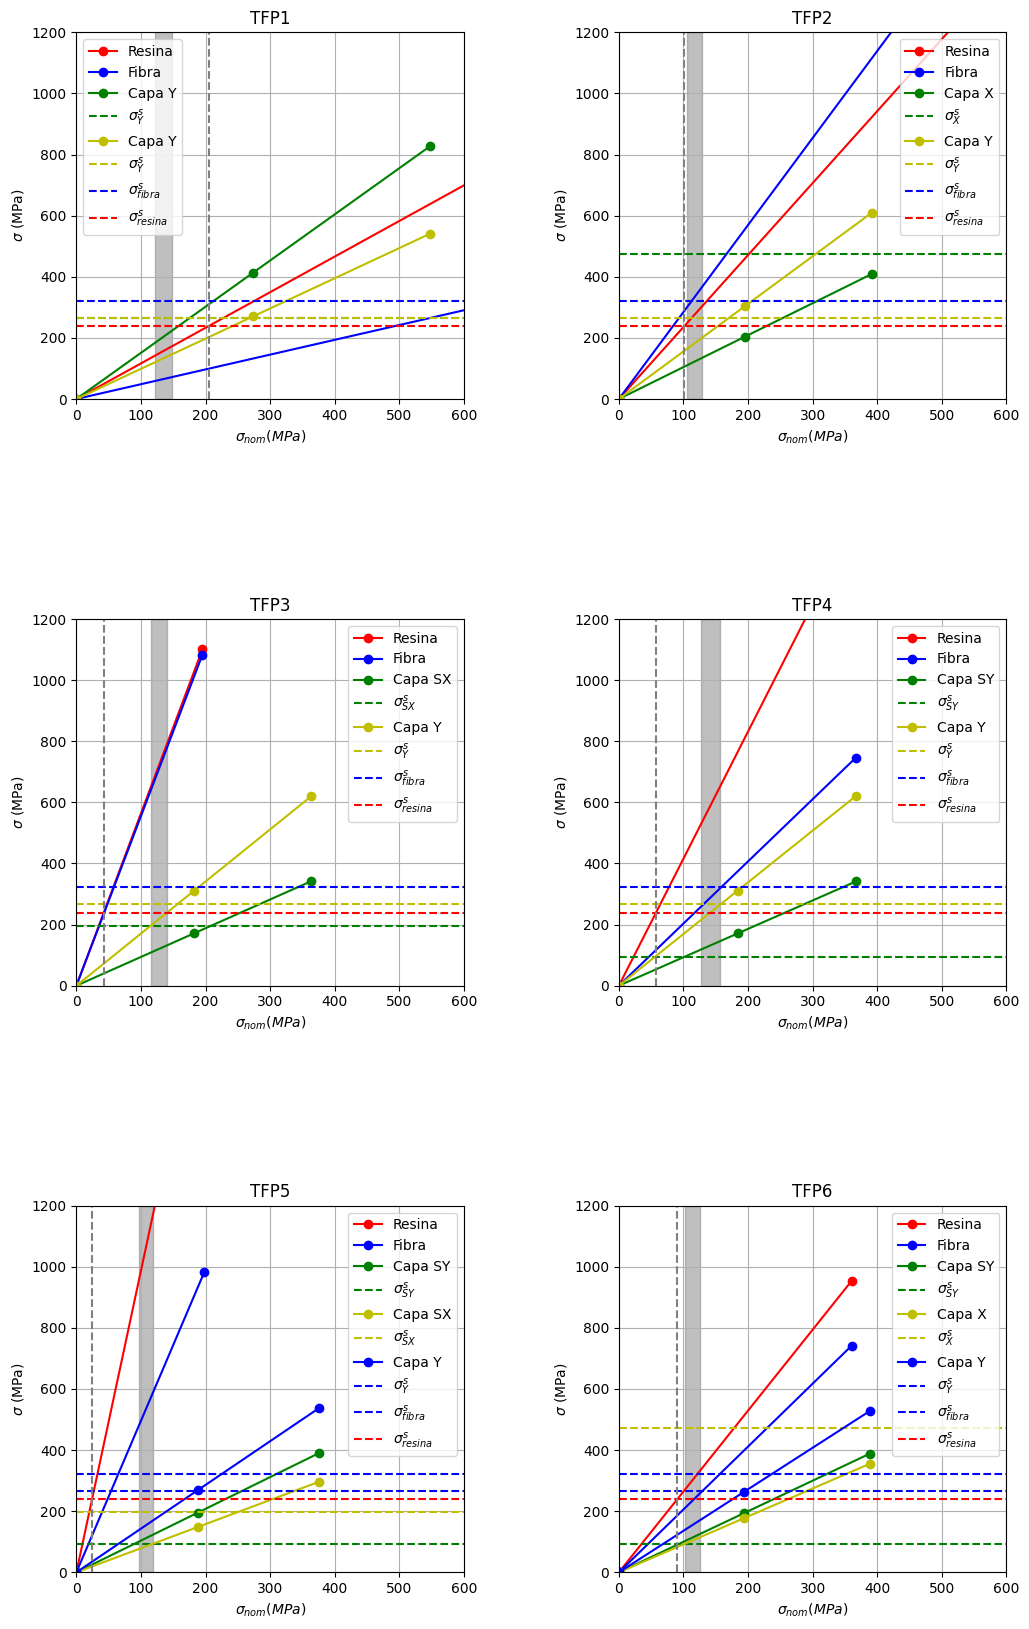

In [44]:
fig = plt.figure(figsize=(12,20))
#padding between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)

ncapas = [2,2,2,2,3,3]
colors = ["g","y","b","r","c","m"]
for i in range(6):

    isum = summaries_multicapa[i]
    layers = isum["layers"]
    P1 = isum["P1"]
    plt.subplot(3,2,i+1)
    plt.plot([0,sigma_exp[i]], [0,P1_resina[i]], "o-", label="Resina",color="r")
    plt.plot([0,sigma_exp[i]], [0,P1_max[i]], "o-", label="Fibra",color="b")

    sigma_exp_mc = isum["sigma_exp"]
    for j in range(ncapas[i]):
        plt.plot(sigma_exp_mc, P1[j], "o-", label="Capa "+layers[j],color=colors[j])
        # horizontal line
        plt.axhline(y=St_layers[layers[j]], linestyle='--', label=r"$\sigma_{"+layers[j]+"}^s$",
                    color=colors[j])


    # horizontal line
    plt.axhline(y=P1_fibra_opt, linestyle='--', label="$\sigma_{fibra}^s$",
                color="b")
    plt.axhline(y=P1_resina_opt, linestyle='--', label="$\sigma_{resina}^s$",
                color="r")

    # experimental vertical line
    # 10% rectangle vertical line
    plt.fill_betweenx([0, 1200], 
                      Sb_expiremental[i]-Sb_expiremental[i]*0.1, 
                      Sb_expiremental[i]+Sb_expiremental[i]*0.1, 
                      color="gray", alpha=0.5)
    
    # vertical line
    plt.axvline(x=S_TPFi_opt[i], linestyle='--', color="gray")
    plt.ylabel(r"$\sigma$ (MPa)")
    plt.xlabel(r"$\sigma_{nom} (MPa)$")
    plt.grid()
    plt.title("TFP" + str(i+1))
    plt.ylim(0, 1200)
    plt.xlim(0, 600)
    plt.legend()

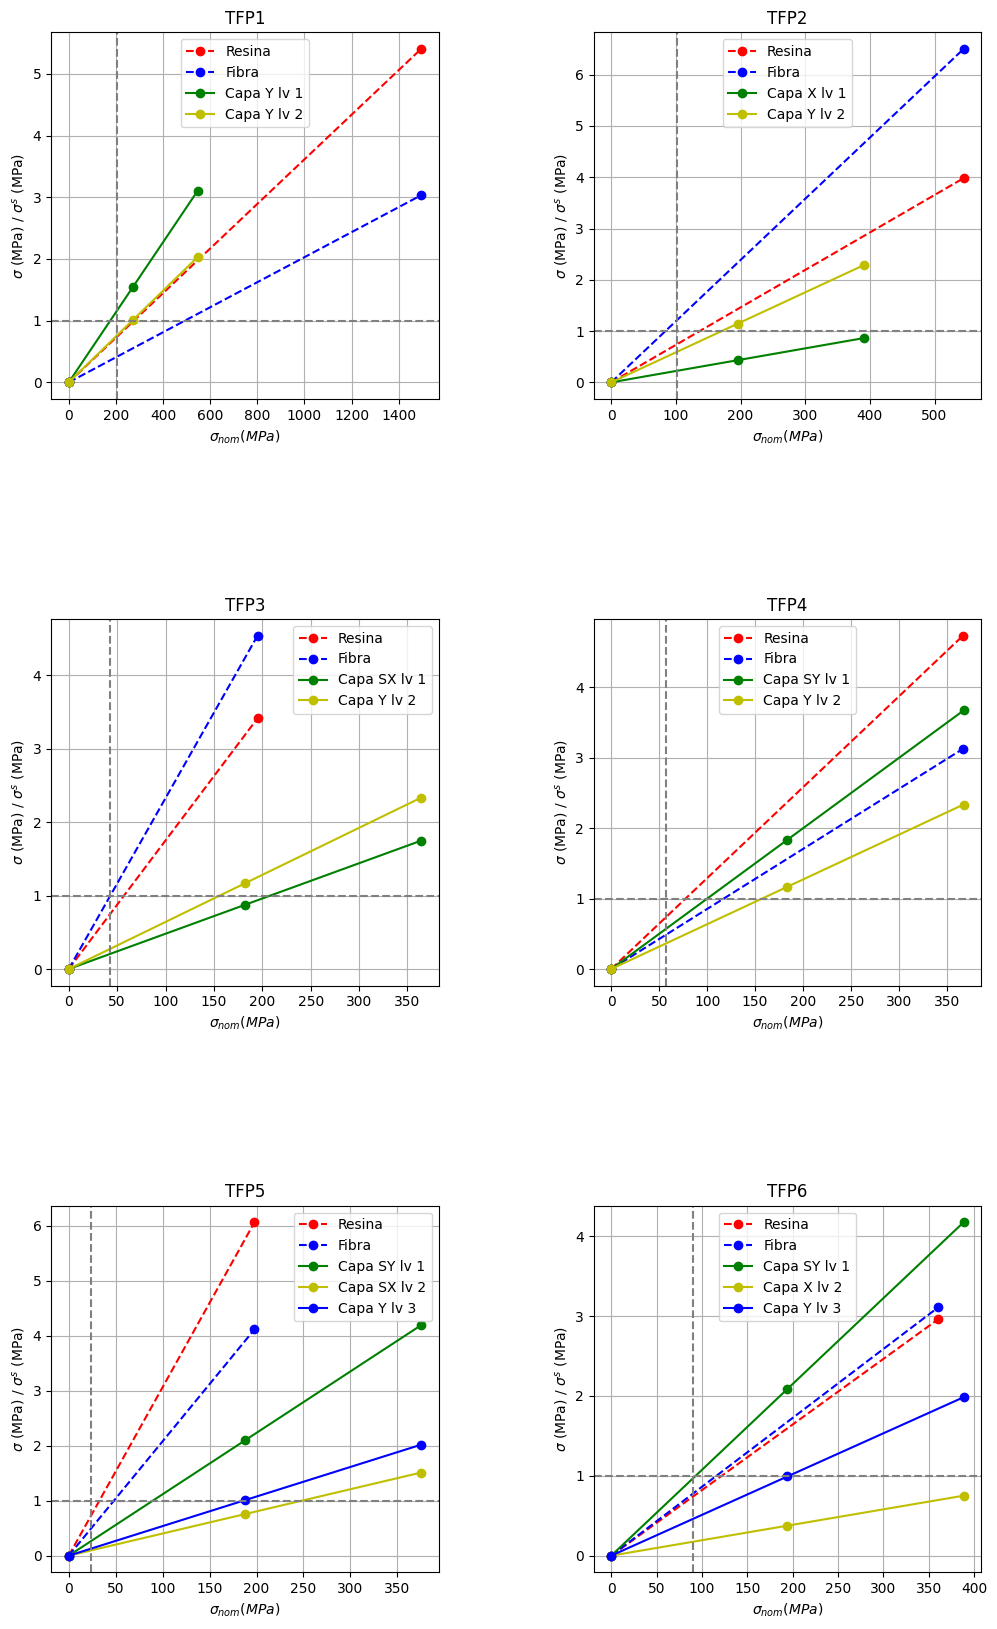

In [45]:
fig = plt.figure(figsize=(12,20))
#padding between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.4)

ncapas = [2,2,2,2,3,3]
colors = ["g","y","b","r","c","m"]
for i in range(6):

    isum = summaries_multicapa[i]
    layers = isum["layers"]
    P1 = isum["P1"]
    plt.subplot(3,2,i+1)
    plt.plot([0,sigma_exp[i]], [0,P1_resina[i]/P1_fibra_opt], "o--", label="Resina",color="r")
    plt.plot([0,sigma_exp[i]], [0,P1_max[i]]/P1_resina_opt, "o--", label="Fibra",color="b")

    sigma_exp_mc = isum["sigma_exp"]
    for j in range(ncapas[i]):

        # damage = P1[j]/St_layers[layers[j]]
        damage = np.array([P1[j][k]/St_layers[layers[j]] for k in range(len(P1[j]))])
        plt.plot(sigma_exp_mc,damage,
                 "o-", label="Capa "+layers[j] + " lv " + str(j+1)
                 ,color=colors[j])


    
    # vertical line
    plt.axvline(x=S_TPFi_opt[i], linestyle='--', color="gray")
    plt.ylabel(r"$\sigma$ (MPa) / $\sigma^s$ (MPa)")
    plt.xlabel(r"$\sigma_{nom} (MPa)$")
    plt.grid()
    plt.title("TFP" + str(i+1))

    ## draw 1 lines horizontal
    plt.axhline(y=1, linestyle='--', color="gray")

    plt.legend()